In [2]:
!git clone https://github.com/v-like-engine/segmentuki

fatal: destination path 'segmentuki' already exists and is not an empty directory.


In [3]:
import sys
sys.path.append("segmentuki")
from models.pix2pixHD.pix2pixHD_model import Pix2PixHD
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm

In [4]:
model = Pix2PixHD()
model.load_state_dict(torch.load("/kaggle/working/segmentuki/models/pix2pixHD/weights/model"))

<All keys matched successfully>

In [5]:
class ADEDataset(Dataset):

    def __init__(self, root_path):
        self.img_path = root_path / "images/training"
        self.mask_path = root_path / "annotations/training"

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((128, 128))
        ])
        self.img_list = sorted(self._get_filenames(self.img_path))
        self.mask_list = sorted(self._get_filenames(self.mask_path))
        
        self._read_imgs()
        self._read_masks()
        
    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]
        return self.transform(img).float(), self.transform(mask).float()

    def __len__(self):
        return len(self.img_list)

    def _get_filenames(self, path):
        return [f for f in path.iterdir() if f.is_file()]

    def _read_imgs(self):
        self.images = [cv2.imread(str(f)) for f in self.img_list]

    def _read_masks(self):
        self.masks = [cv2.imread(str(f)) for f in self.mask_list]

In [6]:
input_dir = "/kaggle/input/ade20k-outdoors"
dataset = ADEDataset(Path(input_dir))

In [7]:
batch_size = 8
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, pin_memory=True
)

In [8]:
def visualize_batch(images, masks, epoch=-1, size=2):
    fig, axs = plt.subplots(size, 2, figsize=(5, 5))
    for i in range(0, size):
        image = images[i].cpu().numpy()
        image = image.transpose((1, 2, 0))
        image = (image * 255.0).astype("uint8")
        
        mask = masks[i].cpu().numpy()
        mask = mask.transpose((1, 2, 0))
        mask = (mask * 255.0).astype("uint8")
        axs[i, 0].imshow(image)
        axs[i, 1].imshow(mask)
        axs[i, 0].axis("off")
        axs[i, 1].axis("off")
    plt.title(f"Epoch: {epoch}")
    plt.tight_layout()
    plt.show()

In [ ]:
batch = next(iter(data_loader))
visualize_batch(batch[0], batch[1], size=4)

In [ ]:
model = Pix2PixHD(device='cuda')

In [9]:
import wandb

wandb.init()

wandb.watch(model, log_freq=100)

wandb: Currently logged in as: slewie. Use `wandb login --relogin` to force relogin


[]

In [ ]:
epochs_num = 30
bar = tqdm(range(epochs_num))
for epoch in bar:
    epoch_loss_G = 0
    epoch_loss_D = 0
    count = 0
    for batch in data_loader:
        images, masks = batch
        images, masks = images.to('cuda'), masks.to('cuda')

        pred = model(masks, images)
        loss_D = (pred[1] + pred[2]) * 0.5
        loss_G = pred[0]
        
        epoch_loss_G += loss_G
        epoch_loss_D += loss_D
        count += 1

        model.optimizer_G.zero_grad()
        loss_G.backward()          
        model.optimizer_G.step()

        model.optimizer_D.zero_grad()
        loss_D.backward()        
        model.optimizer_D.step()
        
        if count % 10 == 0:
            bar.set_postfix_str(f"Generator loss = {epoch_loss_G / count} | Discriminator loss = {epoch_loss_D / count}")
            wandb.log({"generator_loss": loss_G, "discriminator_loss": loss_D})
    if epoch % 5 == 0:
        visualize_batch(images, model.inference(masks), epoch, size=2)
    wandb.log({"generator_epoch_loss": epoch_loss_G / count, "discriminator_epoch_loss": epoch_loss_G / count})

In [1]:
new_epochs_num = 50
bar = tqdm(range(epochs_num, epochs_num + new_epochs_num))
for epoch in bar:
    epoch_loss_G = 0
    epoch_loss_D = 0
    count = 0
    for batch in data_loader:
        images, masks = batch
        images, masks = images.to('cuda'), masks.to('cuda')

        pred = model(masks, images)
        loss_D = (pred[1] + pred[2]) * 0.5
        loss_G = pred[0]
        
        epoch_loss_G += loss_G
        epoch_loss_D += loss_D
        count += 1

        model.optimizer_G.zero_grad()
        loss_G.backward()          
        model.optimizer_G.step()

        model.optimizer_D.zero_grad()
        loss_D.backward()        
        model.optimizer_D.step()
        
        if count % 10 == 0:
            bar.set_postfix_str(f"Generator loss = {epoch_loss_G / count} | Discriminator loss = {epoch_loss_D / count}")
            wandb.log({"generator_loss": loss_G, "discriminator_loss": loss_D})
    if epoch % 5 == 0:
        visualize_batch(images, model.inference(masks), epoch, size=2)
    wandb.log({"generator_epoch_loss": epoch_loss_G / count, "discriminator_epoch_loss": epoch_loss_G / count})

NameError: name 'tqdm' is not defined

  0%|          | 0/70 [02:04<?, ?it/s, Generator loss = 8.414992332458496 | Discriminator loss = 0.012876119464635849]  

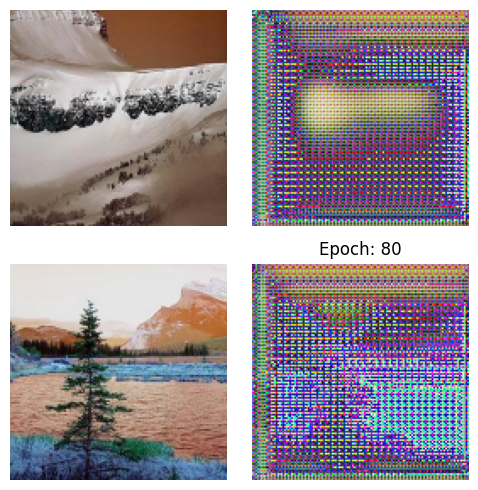

 14%|█▍        | 10/70 [22:59<2:05:24, 125.41s/it, Generator loss = 4.29870080947876 | Discriminator loss = 0.10510463267564774]   

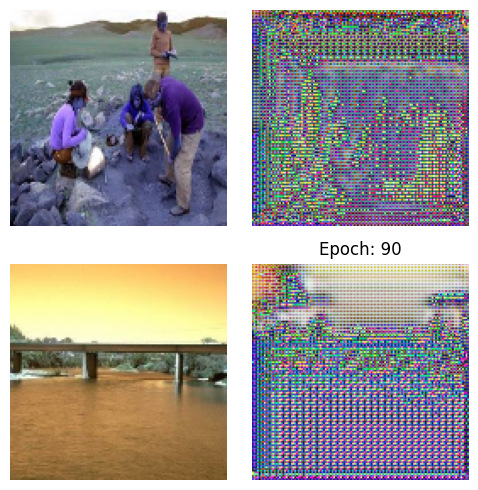

 29%|██▊       | 20/70 [43:52<1:44:23, 125.27s/it, Generator loss = 3.090090751647949 | Discriminator loss = 0.19277285039424896]  

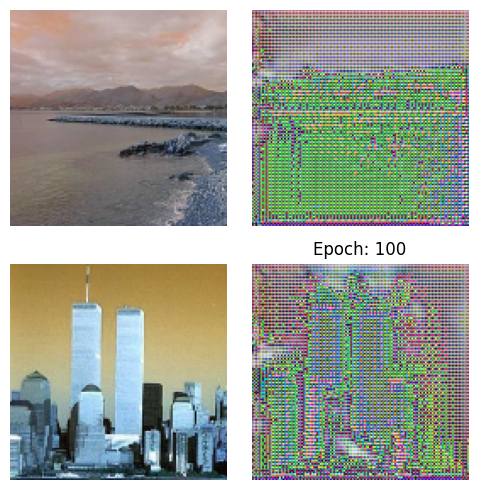

 43%|████▎     | 30/70 [1:04:46<1:23:31, 125.28s/it, Generator loss = 2.8124523162841797 | Discriminator loss = 0.20821763575077057]

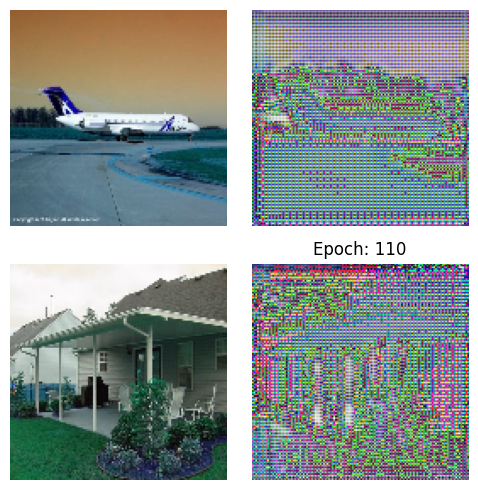

 57%|█████▋    | 40/70 [1:25:39<1:02:38, 125.29s/it, Generator loss = 2.5928099155426025 | Discriminator loss = 0.21557866036891937]

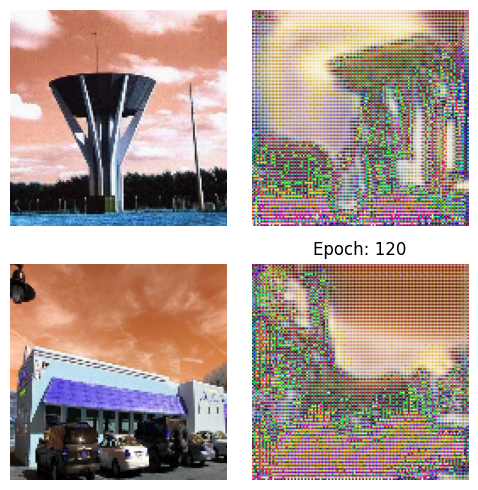

 71%|███████▏  | 50/70 [1:46:34<41:49, 125.46s/it, Generator loss = 2.3748202323913574 | Discriminator loss = 0.24643990397453308]  

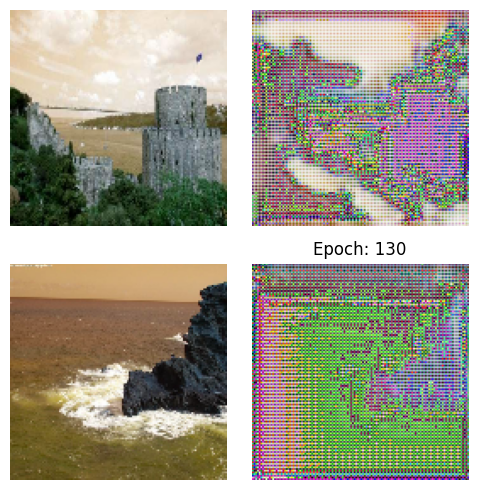

 86%|████████▌ | 60/70 [2:07:28<20:53, 125.36s/it, Generator loss = 2.4001400470733643 | Discriminator loss = 0.24648870527744293]

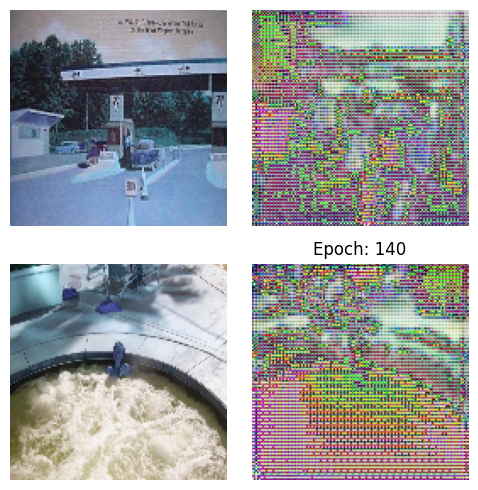

100%|██████████| 70/70 [2:26:19<00:00, 125.42s/it, Generator loss = 2.6768577098846436 | Discriminator loss = 0.20601814985275269]


In [11]:
new_epochs_num = 70
bar = tqdm(range(80, 80 + new_epochs_num))
for epoch in bar:
    epoch_loss_G = 0
    epoch_loss_D = 0
    count = 0
    for batch in data_loader:
        images, masks = batch
        images, masks = images.to('cuda'), masks.to('cuda')

        pred = model(masks, images)
        loss_D = (pred[1] + pred[2]) * 0.5
        loss_G = pred[0]
        
        epoch_loss_G += loss_G
        epoch_loss_D += loss_D
        count += 1

        model.optimizer_G.zero_grad()
        loss_G.backward()          
        model.optimizer_G.step()

        model.optimizer_D.zero_grad()
        loss_D.backward()        
        model.optimizer_D.step()
        
        if count % 10 == 0:
            bar.set_postfix_str(f"Generator loss = {epoch_loss_G / count} | Discriminator loss = {epoch_loss_D / count}")
            wandb.log({"generator_loss": loss_G, "discriminator_loss": loss_D})
    if epoch % 10 == 0:
        visualize_batch(images, model.inference(masks), epoch, size=2)
    wandb.log({"generator_epoch_loss": epoch_loss_G / count, "discriminator_epoch_loss": epoch_loss_G / count})

  0%|          | 0/50 [02:04<?, ?it/s, Generator loss = 2.5677802562713623 | Discriminator loss = 0.25133222341537476]

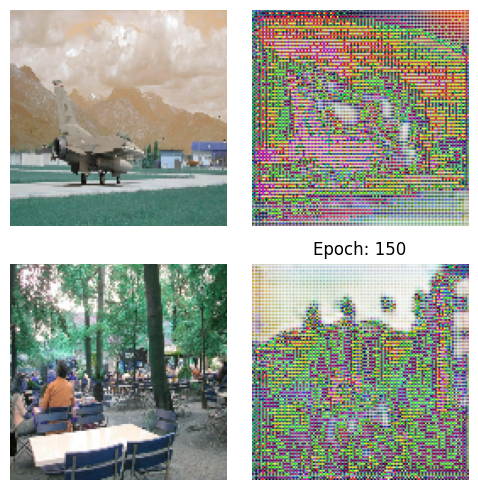

 20%|██        | 10/50 [22:57<1:23:32, 125.32s/it, Generator loss = 2.4319021701812744 | Discriminator loss = 0.24545341730117798]

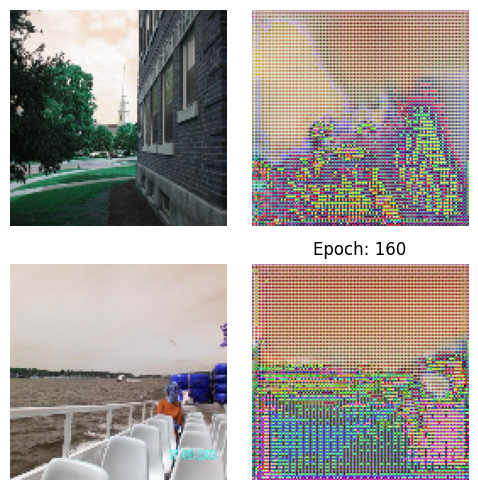

 40%|████      | 20/50 [43:52<1:02:42, 125.41s/it, Generator loss = 2.3062970638275146 | Discriminator loss = 0.2894827425479889] 

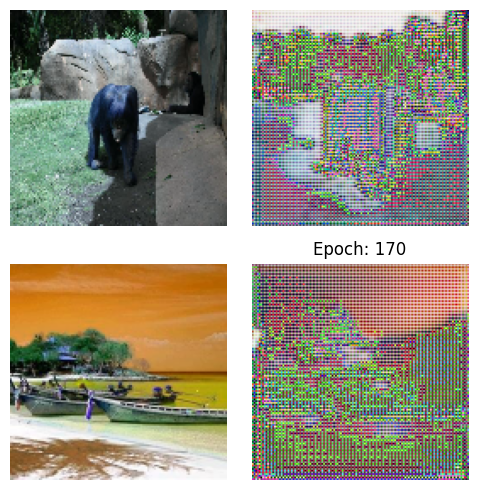

 60%|██████    | 30/50 [1:04:46<41:46, 125.33s/it, Generator loss = 2.442772388458252 | Discriminator loss = 0.24219626188278198] 

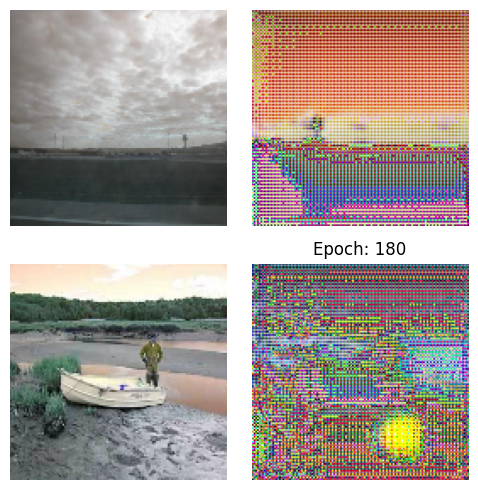

 80%|████████  | 40/50 [1:25:41<20:54, 125.40s/it, Generator loss = 2.4562923908233643 | Discriminator loss = 0.2320680171251297] 

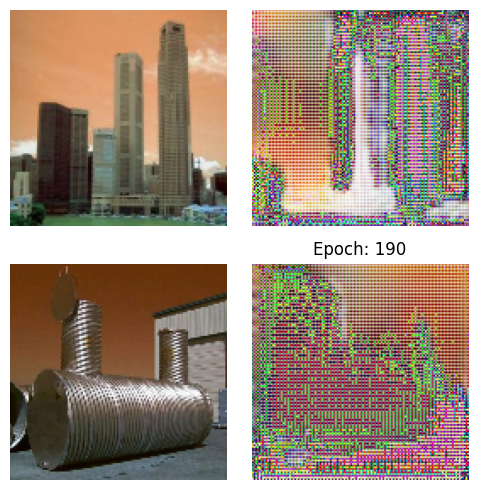

100%|██████████| 50/50 [1:44:30<00:00, 125.41s/it, Generator loss = 2.693732738494873 | Discriminator loss = 0.21360933780670166]  


In [16]:
new_epochs_num = 50
bar = tqdm(range(150, 150 + new_epochs_num))
for epoch in bar:
    epoch_loss_G = 0
    epoch_loss_D = 0
    count = 0
    for batch in data_loader:
        images, masks = batch
        images, masks = images.to('cuda'), masks.to('cuda')

        pred = model(masks, images)
        loss_D = (pred[1] + pred[2]) * 0.5
        loss_G = pred[0]
        
        epoch_loss_G += loss_G
        epoch_loss_D += loss_D
        count += 1

        model.optimizer_G.zero_grad()
        loss_G.backward()          
        model.optimizer_G.step()

        model.optimizer_D.zero_grad()
        loss_D.backward()        
        model.optimizer_D.step()
        
        if count % 10 == 0:
            bar.set_postfix_str(f"Generator loss = {epoch_loss_G / count} | Discriminator loss = {epoch_loss_D / count}")
            wandb.log({"generator_loss": loss_G, "discriminator_loss": loss_D})
    if epoch % 10 == 0:
        visualize_batch(images, model.inference(masks), epoch, size=2)
    wandb.log({"generator_epoch_loss": epoch_loss_G / count, "discriminator_epoch_loss": epoch_loss_G / count})

In [17]:
torch.save(model.state_dict(), './model_ade_128_200')

In [18]:
image = Image.open('/kaggle/working/segmentuki/data/train_img/aachen_000000_000019_leftImg8bit.png')

transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize((128, 128))
])

img_tensor = transform(image).unsqueeze(0).float().to('cuda')
res = model.inference(img_tensor)

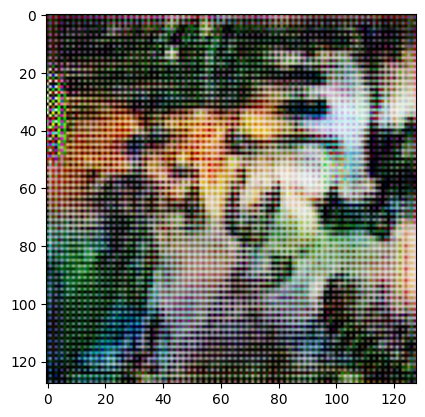

In [19]:
plt.imshow(res.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())

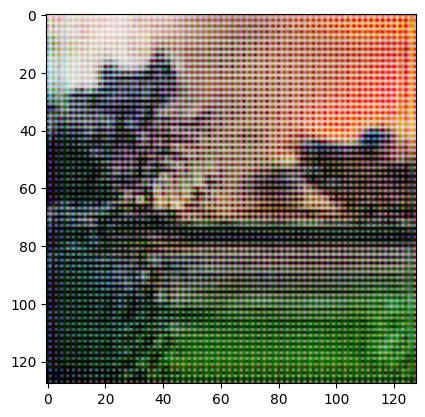

In [20]:
batch = next(iter(data_loader))
plt.imshow(model.inference(batch[1].to('cuda'))[0].squeeze(0).permute(1, 2, 0).cpu().detach().numpy())